Pontificia Universidad Católica de Chile

Escuela de Ingeniería

Departamento de Ingeniería Eléctrica

IEE3936 - Estimación y Control Óptimo en Robótica

<p align="center">
  Tarea 4: Control Óptimo
  <br>
  04 de julio 23:59 hrs
  <br>
  Diego Muñoz Rojas
</p>

In [2]:
# seguimiento de la trayectoria 2D
# movimiento lateral-direccional de un vehiculo de traccion diferencial con GPS.
# importar librerias
import numpy as np
from scipy.linalg import expm, solve_discrete_are
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
import sys
from step_model import step_model as step_model
from modelo_vehiculo import modelo_vehiculo as modelo_vehiculo
from jacobianos_vehiculo import jacobianos_vehiculo as jacobianos_vehiculo
from modelo_sensor import modelo_sensor as modelo_sensor 
from params_vehiculo import *
from scipy.linalg import solve_discrete_are

Pregunta 1: Controlador LQI discreto

In [3]:
def simulador_lqi_discreto(t, x0, P0, sigma_v, sigma_w, sensor, jacob, t1, t2, t3, t4, grafico = False, trayectoria='cuadrada'):
    # listas
    lista_ref_x = []
    lista_ref_y = []
    lista_ref_a = []

    x = x0.reshape((1, len(x0))) # estado real con perturbaciones
    x_k_k = x0.reshape((1, len(x0))) # estado estimado
    x_k1_k = x0.reshape((1, len(x0))) # estado predicho
    z_k = modelo_sensor(x0, sensor) # vector de medicion
    z_k = z_k.reshape((1, len(z_k)))

    P_k_k = P0[np.newaxis,...] # matriz de covarianza del estado estimado
    P_k1_k = P0[np.newaxis,...] # matriz de covarianza del estado predicho

    Q_k = np.diag(sigma_v**2)
    R_k = np.diag(sigma_w**2)

    #u = np.ones((len(t),2))
    u = np.ones((len(t),5))

    # --- Ganancias LQR.
    #Q_lqr = np.array([[0.5,0.,0.,0.,0.],
    #                 [0.,0.5,0.,0.,0.],
    #                 [0.,0.,1.,0.,0.],
    #                 [0.,0.,0.,0.5,0.],
    #                 [0.,0.,0.,0.,0.01]])
    #R_lqr = np.array([[0.5, 0.0],
    #                  [0.0, 0.5]])
    #Q_lqr = np.array([[1,0.,0.,0.,0., 0, 0, 0],
    #                 [0.,1,0,0.,0., 0, 0, 0],
    #                 [0.,0.,1,0,0.,0, 0, 0],
    #                 [0.,0.,0.,1,0.,0, 0, 0],
    #                 [0.,0.,0.,0.,1, 0, 0, 0],
    #                 [0.,0.,0.,0.,0, 1/4, 0, 0],
    #                 [0.,0.,0.,0.,0, 0, 1/4, 0],
    #                 [0.,0.,0.,0.,0, 0, 0, 1/np.pi**2]])
    Q_lqr = np.array([[1.5,0.,0.,0.,0., 0, 0, 0],
                     [0.,1.5,0,0.,0., 0, 0, 0],
                     [0.,0.,0.01,0,0.,0, 0, 0],
                     [0.,0.,0.,1,0.,0, 0, 0],
                     [0.,0.,0.,0.,4, 0, 0, 0],
                     [0.,0.,0.,0.,0, 1/4**2, 0, 0],
                     [0.,0.,0.,0.,0, 0, 1/4**2, 0],
                     [0.,0.,0.,0.,0, 0, 0, 5000]])
    R_lqr = np.array([[0.5, 0.0, 0, 0, 0],
                      [0.0, 0.5, 0, 0, 0],
                      [0.0, 0, 10000000, 0, 0],
                      [0.0, 0, 0, 10000000, 0],
                      [0.0, 0, 0, 0, 10000000]])

    # --- Ganancias control proporcional
    #Kpos = 0.3
    #Ktheta = 0.5
    #Kpos = 2
    #Ktheta = 40

    #Kpos_p = 2
    #Kpos_i = 0.1*Ts
    #Kpos_d = 0/Ts
    #Ktheta_p = 40
    #Ktheta_i = 10*Ts
    #Ktheta_d = 0/Ts

    Kpos_p = 8
    Kpos_i = 0*Ts
    Kpos_d = 0/Ts
    Ktheta_p = 200
    Ktheta_i = 0*Ts
    Ktheta_d = 0/Ts

    u_pid = np.array([0, 0])
    #u_pid = np.array([0, 0, 0, 0, 0])
    err_d = 0
    prev_err1_d = err_d
    prev_err2_d = prev_err1_d
    err_a = 0
    prev_err1_a = err_a
    prev_err2_a = prev_err1_a

    # --- Inicializa el gráfico ---
    if trayectoria == 'cuadrada':
        ref = referencias(0*Ts, t1, t2, t3, t4)
        refx = ref[0]
        refy = ref[1]
    elif trayectoria == 'circular':
        ref = referencias_circular(t, 0, 1/tf)
        refx = ref[0]
        refy = ref[1]

    ref_angle0 = 0
    #fig1 = InitPlot(x, x_k_k, z_k, x_r)

    lista_ref_x.append(refx)
    lista_ref_y.append(refy)
    lista_ref_a.append(ref_angle0)
    lista_error_posicion = [0]
    lista_error_rumbo = [0]
    lista_valor_fo = [0]
    
    err_posx = 0
    err_posy = 0
    err_a = 0
    #x[0, 5:8] = [err_posx, err_posy, err_a]
    # calcular iteraciones del filtro
    for k in range(len(t)-1):
        # jacobianos del modelo continuo
        A, B, G, C, D, H = jacobianos_vehiculo(x_k_k[k,:], u[k-1,:], jacob)
        # jacobianos modelo discreto
        Ad = expm(A*Ts)
        Bd = ((Ad*Ts).dot(np.eye(len(Ad))-A*Ts/2.)).dot(B)
        Gd = ((Ad*Ts).dot(np.eye(len(Ad))-A*Ts/2.)).dot(G)
        A = Ad
        B = Bd
        G = Gd
        # ref
        if trayectoria == 'cuadrada':
            ref = referencias(k*Ts, t1, t2, t3, t4)
            refx = ref[0]
            refy = ref[1]
        elif trayectoria == 'circular':
            ref = referencias_circular(t, k, 1/tf)
            refx = ref[0]
            refy = ref[1]
        # error 
        err_posx = refx - x_k_k[k,0]
        err_posy = refy - x_k_k[k,1]
        err_d = np.sqrt(err_posx**2 + err_posy**2)
        ref_angle = math.atan2(err_posy, err_posx)
        err_a = ref_angle - x_k_k[k,2]
        # logica de calculo distancia de giro mas corta
        if err_a < -np.pi:
            err_a = err_a + 2*np.pi
            ref_angle = ref_angle + 2*np.pi
        elif err_a > np.pi:
            err_a = err_a - 2*np.pi
            ref_angle = ref_angle - 2*np.pi
        ref = np.array([refx, refy, ref_angle, 0, 0])
        #ref = ref.reshape(5, 1)

        #self.prev_u_a + (self.Kpa_d + self.Kia_d + self.Kda_d)*err_a - (self.Kpa_d + 2*self.Kda_d)*self.prev_err1_a + self.Kda_d*self.prev_err2_a
        u_pid_pos = (Kpos_p + Kpos_i + Kpos_d)*err_d - (Kpos_p + 2*Kpos_d)*prev_err1_d + Kpos_d*prev_err2_d
        u_pid_a = (Ktheta_p + Ktheta_i + Ktheta_d)*err_a - (Ktheta_p + 2*Ktheta_d)*prev_err1_a + Ktheta_d*prev_err2_a
        u_pid = u_pid + np.array([u_pid_pos + u_pid_a, u_pid_pos - u_pid_a])
        ruido = np.random.normal(0, 0.0001, A.shape)  # media 0 y desviación estándar 0.1
        A = A + ruido
        P = solve_discrete_are(A, B, Q_lqr, R_lqr)
        # K = (R+B^T*P*B)^{-1}*(B^T*P*A+N^T), N=0 -> 
        K = np.linalg.inv(R_lqr+B.T.dot(P).dot(B)).dot(B.T).dot(P).dot(A)
        #x_k_k[k,5:8] = [err_posx, err_posy, err_a]
        #print(x_k_k)
        u_lqr = -K.dot(x_k_k[k,:])
        #u_lqr = -K.dot(x_aumentado)
        u[k,:] = np.array([u_lqr[0] + u_pid[0], u_lqr[1] + u_pid[1], refx, refy, ref_angle])
        #u[k,:] = u_lqr + u_pid*0
        #u[k,:] = u_aux
        # restricciones

        t_aux, x_aux = step_model(modelo_vehiculo, u[k,:], 0*sigma_v, t[k], Ts, x[k, :])
        x = np.vstack((x,(x_aux.T)[-1,:])) # medicion real
        # Predicción por integración exacta del modelo linealizado
        t_aux, x_aux = step_model(modelo_vehiculo, u[k,:], sigma_v*0, t[k], Ts, x_k_k[k,:])
        x_k1_k_aux = (x_aux.T)[-1,:]
        x_k1_k = np.vstack((x_k1_k, x_k1_k_aux))                             # Store x_{k|k-1}
        z_k1_k_aux = C.dot(x_k1_k[k+1, :]) + D.dot(u[k,:])      # z_{k|k-1}
        #x_k1_k = Ts*modelo_auto(t[k], x[k, :], lista_entradas[k,:], 0*sigma_v) + x_k_k[k, :]
        #z_k1_k_aux = modelo_sensor(x_k1_k[k+1, :], 0*sigma_w)
        # prediccion de matriz de covarianza
        P_k1_k_aux = (A.dot(P_k_k[k,:,:])).dot(A.T) + (G.dot(Q_k)).dot(G.T)  # Px_{k|k-1}
        S_k1_k_aux = (C.dot(P_k1_k_aux)).dot(C.T) + (H.dot(R_k)).dot(H.T)    # S_{k|k-1}
        # Actualizacion/correccion del estado y covarianza del proceso
        z_k1_aux = modelo_sensor(x[k+1,:], sensor)           # z_{k}
        e = z_k1_aux - z_k1_k_aux                                            # e_{k}
        K = (P_k1_k_aux.dot(C.T)).dot(np.linalg.inv(S_k1_k_aux))             # K_{k}
        x_k_k_aux = x_k1_k[k+1,:] + K.dot(e)                                 # x_{k|k}
        P_k_k_aux = P_k1_k_aux - (K.dot(S_k1_k_aux)).dot(K.T)                # P_{k|k}
        z_k = np.vstack((z_k, z_k1_aux))                                     # Store z_{k}
        x_k_k = np.vstack((x_k_k, x_k_k_aux))                                # Store x_{k|k}
        P_k_k = np.vstack((P_k_k, P_k_k_aux[np.newaxis,...]))                # Store P_{k|k}

        # --- Actualiza el gráfico de simulación ---
        #x_r = np.array([[ref[0], ref[1], ref_angle]])
        #UpdatePlot(fig1, x, x_k_k, z_k, x_r)
        lista_ref_x.append(refx)
        lista_ref_y.append(refy)
        lista_ref_a.append(ref_angle)
        lista_error_posicion.append(err_d)
        lista_error_rumbo.append(err_a)
        prev_err2_a = prev_err1_a
        prev_err1_a = err_a
        prev_err2_d = prev_err1_d
        prev_err1_d = err_d
        fo = funcion_objetivo(x_k_k[k,:], u[k,:], Q_lqr, R_lqr, ref)
        lista_valor_fo.append(fo)
        #print(k*Ts)
    # end for loop
    if grafico == True:
        # Graficos de resultados
        plt.ioff() 
        fig2 = plt.figure()
        fig2.canvas.manager.set_window_title('Estado x: Medido, Real, Predicho, Filtrado y Referencia')
        plt.title('Estado X: Medido, Real, Predicho, Filtrado y Referencia')
        plt.plot(t, z_k[:,0], linewidth = 5)
        plt.plot(t, x[:,0], linewidth = 4)
        plt.plot(t, x_k1_k[:,0], t, x_k_k[:,0], linewidth = 3)
        plt.plot(t, lista_ref_x, '--k')
        plt.xlabel('Tiempo [s]')
        plt.ylabel('X [m]')
        plt.legend(('X medido','X real','X predicho','X filtrado','X referencia'))
        plt.show()
            
        fig3 = plt.figure()
        fig3.canvas.manager.set_window_title('Posición (X,Y): Medida, Real, Predicha, Filtrada y Referencia')
        plt.title('Posición (X,Y): Medida, Real, Predicha, Filtrada y Referencia')
        plt.plot(z_k[:,0], z_k[:,1], linewidth = 5)
        plt.plot(x[:,0], x[:,1], linewidth = 4)
        plt.plot(x_k1_k[:,0], x_k1_k[:,1], x_k_k[:,0], x_k_k[:,1], lista_ref_x, lista_ref_y, linewidth = 3)
        plt.xlabel('X (X>0 -> este) [m]')
        plt.ylabel('Y (Y>0 -> norte) [m]')
        plt.legend(('(X,Y) medido','(X,Y) real','(X,Y) predicho','(X,Y) filtrado', '(X,Y) referencia'))  
        plt.axis('equal')
        plt.axis('square')
        #plt.axis([-3, 3, -3, 3])
        plt.gca().set_aspect('equal', 'box')
        plt.show()

        fig4 = plt.figure()
        fig4.canvas.manager.set_window_title('Error de posición')
        plt.title('Error de posición')
        plt.plot(t, lista_error_posicion, linewidth = 3)
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Error de posición [m]')
        plt.show()
        fig5 = plt.figure()
        fig5.canvas.manager.set_window_title('Error de rumbo')
        plt.title('Error de rumbo')
        plt.plot(t, np.array(lista_error_rumbo)*180/np.pi, linewidth = 3)
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Error de rumbo [°]')
        plt.show()
        ITAE_pos = calcular_ITAE(lista_error_posicion)
        fig6 = plt.figure()
        fig6.canvas.manager.set_window_title('ITAE de posición')
        plt.title('ITAE de posición')
        plt.plot(t, ITAE_pos, linewidth = 3)
        plt.xlabel('Tiempo [s]')
        plt.ylabel('ITAE de posición')
        plt.show()
        ITAE_rumbo = calcular_ITAE(lista_error_rumbo)
        fig6 = plt.figure()
        fig6.canvas.manager.set_window_title('ITAE de rumbo')
        plt.title('ITAE de rumbo')
        plt.plot(t, np.array(ITAE_rumbo)*180/np.pi, linewidth = 3)
        plt.xlabel('Tiempo [s]')
        plt.ylabel('ITAE de rumbo')
        plt.show()
        fo_sum = funcion_objetivo_tiempo(lista_valor_fo)
        fig7 = plt.figure()
        fig7.canvas.manager.set_window_title('Función objetivo')
        plt.title('Función objetivo')
        plt.plot(t, fo_sum, linewidth = 3)
        plt.xlabel('Tiempo [s]')
        plt.ylabel('J')
        plt.show()
        grafico_estado(x, lista_ref_x, lista_ref_y, np.array(lista_ref_a))
        grafico_torques_entrada(u)
        grafico_aceleracion(x)
    return u, lista_error_posicion, lista_error_rumbo

Graficos LQI discreto:

In [4]:
def InitPlot(x, x_k_k, z_k, x_r):
    plt.ion() # https://stackoverflow.com/questions/4098131/how-to-update-a-plot-in-matplotlib    
    Ar = 0.3 # Heading arrow
    # Plotea valores iniciales
    fig1 = plt.figure()
    fig1.canvas.manager.set_window_title('Simulación')
    # Estado real
    plt.plot(x[-1,0], x[-1,1], 'bo')
    plt.plot([x[-1,0], x[-1,0]+Ar*np.cos(x[-1,2])], [x[-1,1], x[-1,1]+Ar*np.sin(x[-1,2])],'b')
    # Estado filtrado
    plt.plot(x_k_k[-1,0], x_k_k[-1,1], 'go')
    plt.plot([x_k_k[-1,0], x_k_k[-1,0]+Ar*np.cos(x_k_k[-1,2])], [x_k_k[-1,1], x_k_k[-1,1]+Ar*np.sin(x_k_k[-1,2])],'g')
    # Estado medido
    plt.plot(z_k[-1,0], z_k[-1,1], 'ro')
    plt.plot([z_k[-1,0], z_k[-1,0]+Ar*np.cos(z_k[-1,2])], [z_k[-1,1], z_k[-1,1]+Ar*np.sin(z_k[-1,2])],'r')
    # Estado referncia
    plt.plot(x_r[-1,0], x_r[-1,1], 'mo')
    plt.plot([x_r[-1,0], x_r[-1,0]+Ar*np.cos(x_r[-1,2])], [x_r[-1,1], x_r[-1,1]+Ar*np.sin(x_r[-1,2])],'m')
    #
    plt.xlabel('x (x>0 -> este) (m)')
    plt.ylabel('y (y>0 -> norte) (m)')
    mark_real = mlines.Line2D([], [], color='blue', marker='o', label='(x,y) real')
    mark_filt = mlines.Line2D([], [], color='green', marker='o', label='(x,y) filtrado')
    mark_medi = mlines.Line2D([], [], color='red', marker='o', label='(x,y) medido')
    mark_ref  = mlines.Line2D([], [], color='m', marker='o', label='(x,y) referencia')
    plt.legend(handles=[mark_real, mark_filt, mark_medi, mark_ref])
    plt.axis([-2., 5., -2., 5.])
    #plt.show()
    fig1.canvas.draw()
    fig1.canvas.flush_events()
    
    # # Graficos de resultados
    # fig1 = plt.figure()
    # fig1.canvas.set_window_title('Estado x: Real, Predicho, Filtrado, y Medido')
    # plt.plot(t, x[:,0], t, x_k1_k[:,0], t, x_k_k[:,0], t, z_k[:,0])    
    # plt.xlabel('t [h]')
    # plt.ylabel('x [km]')
    # plt.legend(('x real','x predicho','x filtrado','x medido'))
    
    return fig1
def UpdatePlot(fig1, x, x_k_k, z_k, x_r):
 
    #fig1.clear()

    Ar = 0.3 # Heading arrow
    # Estado real
    plt.plot(x[-1,0], x[-1,1], 'bo')
    plt.plot([x[-1,0], x[-1,0]+Ar*np.cos(x[-1,2])], [x[-1,1], x[-1,1]+Ar*np.sin(x[-1,2])],'b')
    # Estado filtrado
    plt.plot(x_k_k[-1,0], x_k_k[-1,1], 'go')
    plt.plot([x_k_k[-1,0], x_k_k[-1,0]+Ar*np.cos(x_k_k[-1,2])], [x_k_k[-1,1], x_k_k[-1,1]+Ar*np.sin(x_k_k[-1,2])],'g')
    # Estado medido
    plt.plot(z_k[-1,0], z_k[-1,1], 'ro')
    plt.plot([z_k[-1,0], z_k[-1,0]+Ar*np.cos(z_k[-1,2])], [z_k[-1,1], z_k[-1,1]+Ar*np.sin(z_k[-1,2])],'r')
    # Estado referncia
    plt.plot(x_r[-1,0], x_r[-1,1], 'mo')
    plt.plot([x_r[-1,0], x_r[-1,0]+Ar*np.cos(x_r[-1,2])], [x_r[-1,1], x_r[-1,1]+Ar*np.sin(x_r[-1,2])],'m')
    #
    plt.xlabel('x (x>0 -> este) (m)')
    plt.ylabel('y (y>0 -> norte) (m)')
    mark_real = mlines.Line2D([], [], color='blue', marker='o', label='(x,y) real')
    mark_filt = mlines.Line2D([], [], color='green', marker='o', label='(x,y) filtrado')
    mark_medi = mlines.Line2D([], [], color='red', marker='o', label='(x,y) medido')
    mark_ref  = mlines.Line2D([], [], color='m', marker='o', label='(x,y) referencia')
    plt.legend(handles=[mark_real, mark_filt, mark_medi, mark_ref])
    plt.axis('equal')
    plt.axis('square')
    plt.axis([-2., 5., -2., 5.])
    plt.gca().set_aspect('equal', 'box')
    #plt.show()
    fig1.canvas.draw()
    fig1.canvas.flush_events()

Funciones cálculo de métricas de desempeño

In [5]:
def calcular_ITAE(error):
    lista_ITAE = []
    for i in range(len(error)):
        ITAE = np.sum(np.abs(error[:i]) * Ts)
        lista_ITAE.append(ITAE)
    return lista_ITAE

def funcion_objetivo(x, u, Q, R, ref):
    J = x.T.dot(Q).dot(x) + u.T.dot(R).dot(u)
    #J = (ref - x.T).dot(Q).dot(ref - x) + u.T.dot(R).dot(u)
    return J

def funcion_objetivo_tiempo(lista_fo):
    fo_sum = []
    for i in range(len(lista_fo)):
        fo_acum = np.sum(lista_fo[:i])
        fo_sum.append(fo_acum)
    return fo_sum

Pregunta 3: Controlador PID discreto de ángulo y distancia euclidiana

In [6]:
# control discreto PID de angulo y distancia
class PIDControl:
    def __init__(self, Kpa, Kia, Kda, Kpd, Kid, Kdd, dt=0.01):
        self.dt = dt # periodo de muestreo
        # constantes controlador de angulo discreto
        self.Kpa_d = Kpa
        self.Kia_d = Kia*dt
        self.Kda_d = Kda/dt
        # constantes controlador de distancia euclidiana discreto
        self.Kpd_d = Kpd
        self.Kid_d = Kid*dt
        self.Kdd_d = Kdd/dt
        # errores previos
        self.prev_err1_a = 0
        self.prev_err2_a = 0
        self.prev_err1_d = 0
        self.prev_err2_d = 0
        # entradas previas
        self.prev_u_a = 0
        self.prev_u_d = 0

    def calcular_control(self, estado, ref):
        # calculo error
        refx = ref[0]
        refy = ref[1]
        err_posx = refx - estado[0]
        err_posy = refy - estado[1]
        err_d = np.sqrt(err_posx**2 + err_posy**2)
        ref_angle = math.atan2(err_posy, err_posx)
        err_a = ref_angle - estado[2]
        # logica de calculo distancia de giro mas corta
        if err_a < -np.pi:
            err_a = err_a + 2*np.pi
            ref_angle = ref_angle + 2*np.pi
        elif err_a > np.pi:
            err_a = err_a - 2*np.pi
            ref_angle = ref_angle - 2*np.pi
        
        ############################# controlador discreto ############################
        ua = self.prev_u_a + (self.Kpa_d + self.Kia_d + self.Kda_d)*err_a - (self.Kpa_d + 2*self.Kda_d)*self.prev_err1_a + self.Kda_d*self.prev_err2_a
        ud = self.prev_u_d + (self.Kpd_d + self.Kid_d + self.Kdd_d)*err_d - (self.Kpd_d + 2*self.Kdd_d)*self.prev_err2_d + self.Kdd_d*self.prev_err2_d
        ############################# controlador discreto ############################
        # control en cascada angulo despues distancia
        #if np.abs(err_a) > 1/180*np.pi:
        #    u1 = ua
        #    u2 = - ua
        #else:
        #    u1 = ud
        #    u2 = ud
        u1 = ud + ua
        u2 = ud - ua
        self.prev_err2_a = self.prev_err1_a
        self.prev_err1_a = err_a
        self.prev_err2_d = self.prev_err1_d
        self.prev_err1_d = err_d
        self.prev_u_a = ua
        self.prev_u_d = ud
        senal_control = [u1, u2] # vector de control (torques)
        return senal_control, ref_angle, err_d, err_a

Simulador pregunta 3:

In [7]:
# simulador
def simular_pdi_discreto(t, x, u, sigma_vx, sigma_vu, ref, trayectoria='cuadrada'):
    # valor de constantes de controlador
    #Kpa = 0.5; Kia = 0; Kda = 5
    #Kpd = 0.1; Kid = 0; Kdd = 0
    Kpa = 0.5; Kia = 0; Kda = 5
    Kpd = 0.8; Kid = 0.001; Kdd = 0

    # crear el controlador PID para el angulo y distancia
    pid_controller = PIDControl(Kpa, Kia, Kda, Kpd, Kid, Kdd, Ts)
    # listas para guardar vectores de valores
    lista_x = np.zeros((len(t), len(x)))
    lista_entradas = np.zeros((len(t), len(u)))
    lista_ref_angle = np.zeros((len(t), 1))
    lista_error_pos = np.zeros((len(t), 1))
    lista_error_rumbo = np.zeros((len(t), 1))
    lista_ref_x = np.zeros((len(t), 1))
    lista_ref_y = np.zeros((len(t), 1))
    i = 0 # definimos la referencia en el tiempo e iteramos 
    #ref_circular = referencias_circular(t, 1/tf)
    for t_actual in t:
        if trayectoria == 'cuadrada':
            ref = referencias(t_actual)
            refx = ref[0]
            refy = ref[1]
        elif trayectoria == 'circular':
            ref = referencias_circular(t, i, 1/tf)
            refx = ref[0]
            refy = ref[1]
        # Calcular la señal de control utilizando el controlador PID
        senal_control, ref_angle, err_pos, err_rumbo = pid_controller.calcular_control(x, ref)
        lista_entradas[i,:] = senal_control
        lista_ref_angle[i,:] = ref_angle
        lista_error_pos[i] = err_pos
        lista_error_rumbo[i] = err_rumbo
        lista_ref_x[i] = refx
        lista_ref_y[i] = refy
        # modelo de vehículo con la señal de control aplicada
        t_aux, xaux = step_model(modelo_vehiculo, senal_control, sigma_vx, t_actual, Ts, x)
        x = xaux[:,-1]
        lista_x[i,:] = x
        i += 1
    return lista_x, lista_ref_x, lista_ref_y, lista_entradas, lista_ref_angle, lista_error_pos, lista_error_rumbo

In [8]:
def referencias(t, t1=1.05, t2=1.7, t3=2.2, t4=2.55):
    #t1=0.7; t2=1.3; t3=1.9; t4=2.35
    if t < t1:
        ref = [1, 1]
        #ref = [0, 2]
    elif t >= t1 and t < t2:
        ref = [-1, 1]
    elif t >= t2 and t < t3:
        ref = [-1, -1]
        #ref = [2, 0]
    elif t >= t3 and t < t4:
        ref = [1, -1]
    elif t >= t4:
        ref = [1, 1]
    return ref
def referencias_circular(t, k, frecuencia=1/10):
    x = 1 + np.cos(2 * np.pi * frecuencia * t[k])  # Coordenadas x
    y = 1 + np.sin(2 * np.pi * frecuencia * t[k])  # Coordenadas y
    return [x, y]

Funciones de gráficos

In [9]:
## grafico de posicion x versus y con vector de orientacion
def grafico_xy_orientacion(lista_x, lista_ref_x, lista_ref_y):
    x = lista_x[:, 0]
    y = lista_x[:, 1]
    dx = np.diff(x)/max(np.diff(x))
    dy = np.diff(y)/max(np.diff(y))
    origen_x = x[:-1]
    origen_y = y[:-1]
    fig0, ax = plt.subplots()
    fig0.canvas.manager.set_window_title('Trayectoria')
    ax.plot(x, y, 'o-', label='Posición', zorder=1)
    ax.plot(lista_ref_x, lista_ref_y, '--k', label='referencia')
    ax.quiver(origen_x, origen_y, dx, dy, scale=3, scale_units='xy', angles='xy', color='r', label='Vector de dirección', zorder = 5)
    ax.set_xlim(min(x) - 1, max(x) + 1)
    ax.set_ylim(min(y) - 1, max(y) + 1)
    ax.set_title('Trayectoria X versus Y')
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.legend()
    plt.show()
## grafico de torques de entrada para cada actuador
def grafico_torques_entrada(lista_entradas):
    fig1, (ax1, ax2) = plt.subplots(2, 1)
    fig1.canvas.manager.set_window_title('Entradas')
    ax1.plot(t, lista_entradas[:, 0], 'r')
    ax1.set_title('Entrada actuador derecho')
    ax1.set_ylabel('Td [Nm]')
    ax2.plot(t, lista_entradas[:, 1], 'b')
    ax2.set_title('Entrada actuador izquierdo')
    ax2.set_xlabel('Tiempo [s]')
    ax2.set_ylabel('Ti [Nm]')
    plt.tight_layout()
    plt.show()
### grafico de variables de estado
def grafico_estado(lista_x, lista_ref_x, lista_ref_y, lista_ref_angle):
    titles = ['Posición X [m]', 'Posición Y [m]', 'Ángulo [°]', 'Velocidad angular [rad/s]', 'Velocidad lineal [m/s]', 'Error x', 'Error y', 'Error theta']
    colors = ['r', 'b', 'g', 'm', 'c', 'k', 'r', 'r', 'r']
    for i in range(len(x0)):
        fig2, axs = plt.subplots()
        fig2.canvas.manager.set_window_title('Variables de Estado')
        if i == 0:
            axs.plot(t, lista_x[:, i], colors[i])
            axs.plot(t, lista_ref_x, '--k')
            axs.set_title(titles[i])
            axs.set_xlabel('Tiempo [s]')
            axs.set_ylabel('X [m]')
            pass
        elif i == 1:
            axs.plot(t, lista_x[:, i], colors[i])
            axs.plot(t, lista_ref_y, '--k')
            axs.set_title(titles[i])
            axs.set_xlabel('Tiempo [s]')
            axs.set_ylabel('Y (m)')
        elif i == 2:
            axs.plot(t, lista_x[:, i]*180/np.pi, colors[i], label='Ángulo [°]')
            axs.plot(t, lista_ref_angle*180/np.pi, 'k--', label='Referencia')
            axs.set_title(titles[i])
            axs.set_xlabel('Tiempo [s]')
            axs.set_ylabel('theta [°]')
        elif i == 3:
            axs.plot(t, lista_x[:, i], colors[i])
            axs.set_title(titles[i])
            axs.set_xlabel('Tiempo [s]')
            axs.set_ylabel('V [m/s]')
        elif i == 4:
            axs.plot(t, lista_x[:, i]*180/np.pi, colors[i])
            axs.set_title(titles[i])
            axs.set_xlabel('Tiempo [s]')
            axs.set_ylabel('w [°/s]')
        elif i == 5:
            axs.plot(t, lista_x[:, i]*180/np.pi, colors[i])
            axs.set_title(titles[i])
            axs.set_xlabel('Tiempo [s]')
            axs.set_ylabel('w [°/s]')
        elif i == 6:
            axs.plot(t, lista_x[:, i]*180/np.pi, colors[i])
            axs.set_title(titles[i])
            axs.set_xlabel('Tiempo [s]')
            axs.set_ylabel('w [°/s]')
        elif i == 7:
            axs.plot(t, lista_x[:, i]*180/np.pi, colors[i])
            axs.set_title(titles[i])
            axs.set_xlabel('Tiempo [s]')
            axs.set_ylabel('w [°/s]')
        plt.show()
### perfil de aceleracion
def grafico_aceleracion(lista_x):
    velocidad_lineal = lista_x[:, 3]
    aceleracion_lineal = np.diff(velocidad_lineal)
    fig2 = plt.figure()
    fig2.canvas.manager.set_window_title('Perfil de aceleración lineal')
    plt.plot(t[:-1], aceleracion_lineal, 'r')
    plt.title('Perfil de aceleración lineal')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('a [m/s^2]')
    plt.show()
    velocidad_angular = lista_x[:, 4]
    aceleracion_angular = np.diff(velocidad_angular)
    fig2 = plt.figure()
    fig2.canvas.manager.set_window_title('Perfil de aceleración lineal')
    plt.plot(t[:-1], aceleracion_angular*180/np.pi, 'r')
    plt.title('Perfil de aceleración angular')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('alpha [°/s^2]')
    plt.show()

Simular todo: Se incluye la pregunta 2 con la trayectoria del robot, error de posición, error de rumbo, curvas de ITAE, evolución de función de costo en el tiempo y torques de cada motor en el seguimiento de trayectoria cuadrada de 2x2 m centrada en el origen y una trayectoria circular para circulo de radio 1m.

También se encuentra incluida la pregunta 3 considerando todos los gráficos solicitados para el controlador LQI y se presentan los gráficos comparativos de la respuesta de ambos controladores en cuanto al error de seguimiento y señales de control.

SIMULACIÓN CONTROLADOR LQI DISCRETO


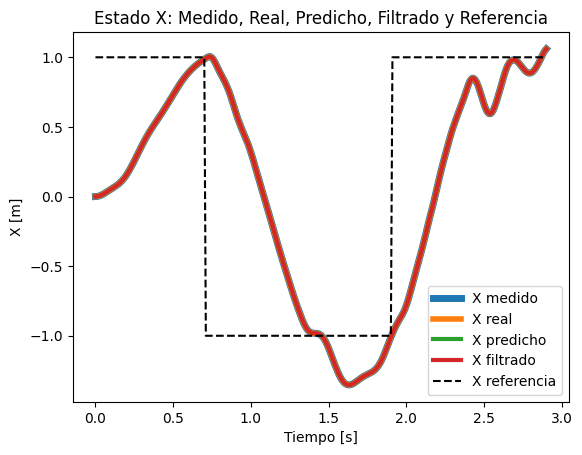

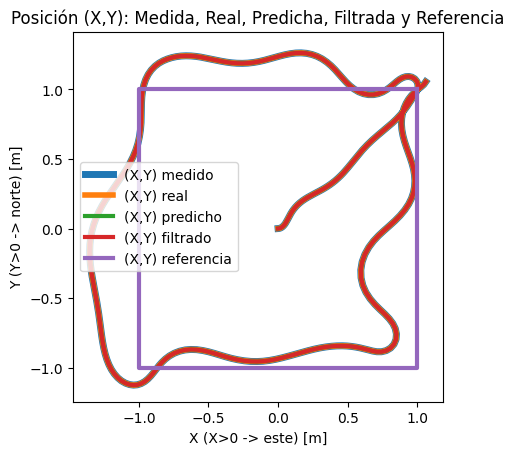

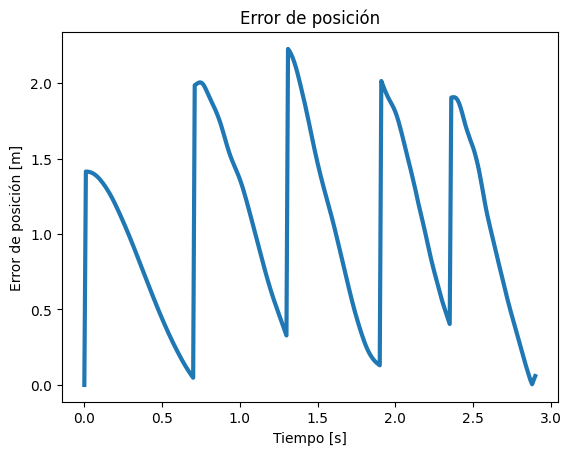

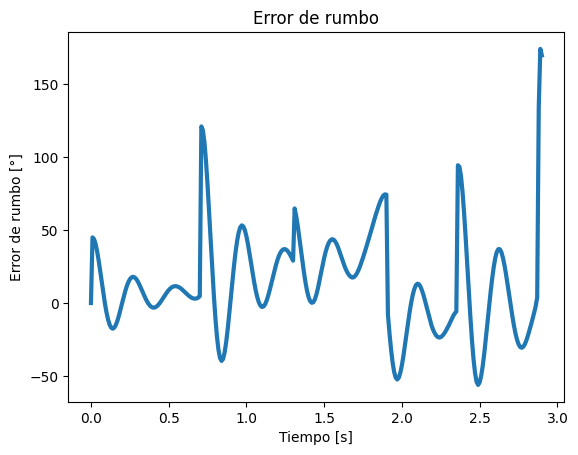

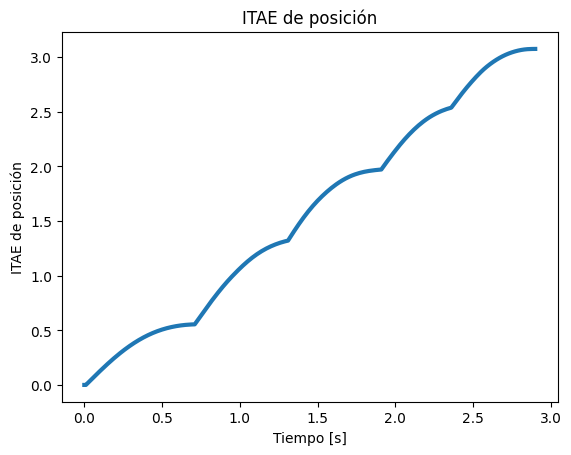

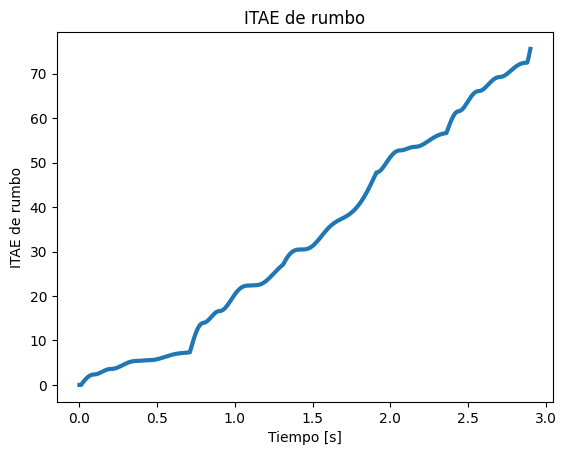

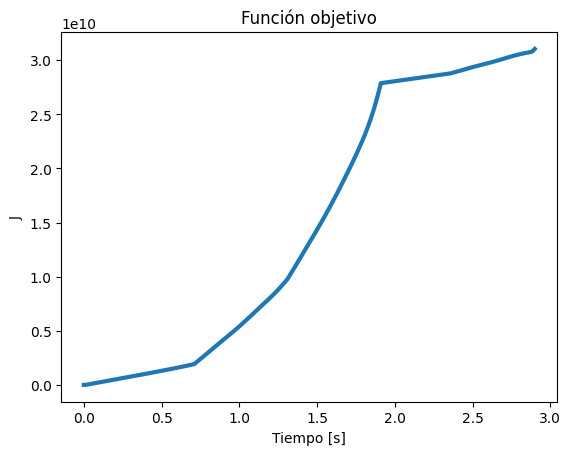

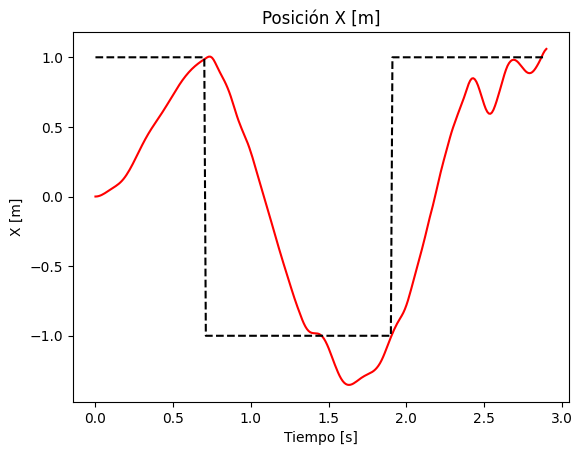

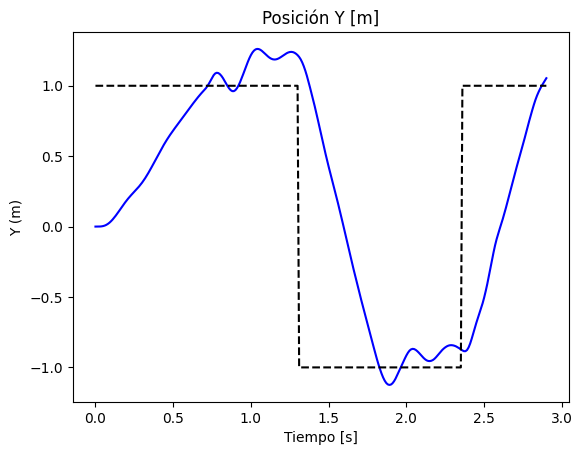

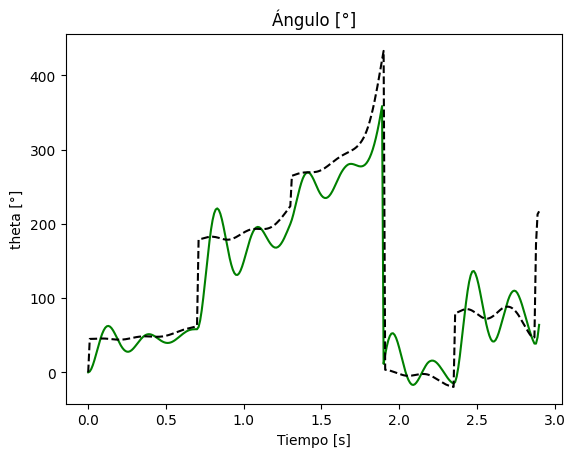

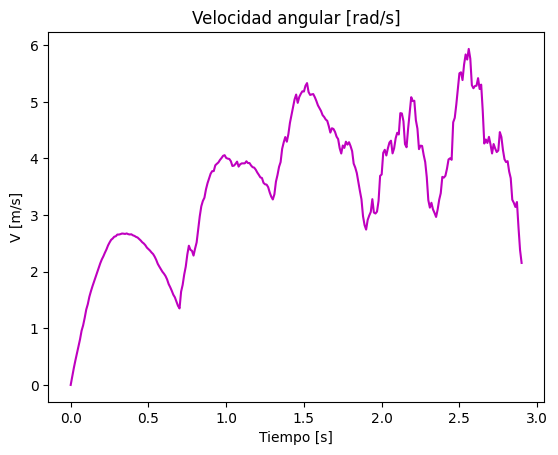

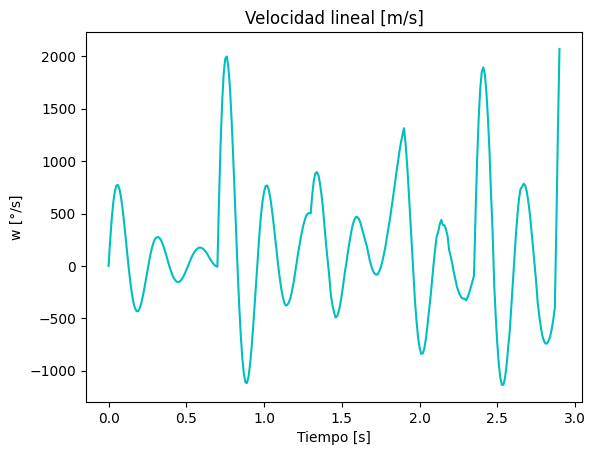

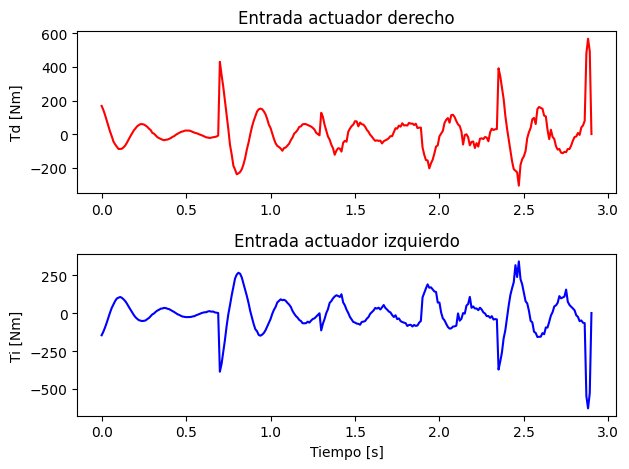

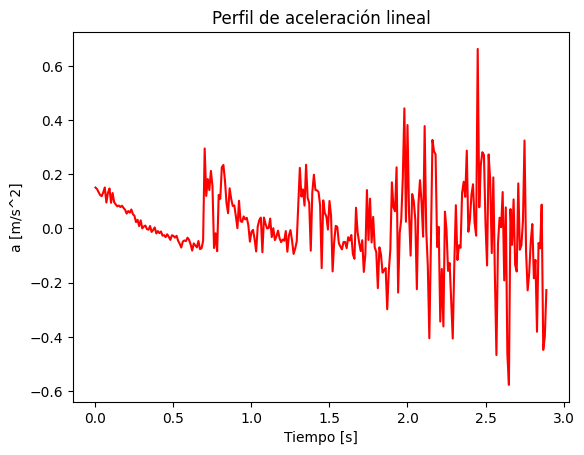

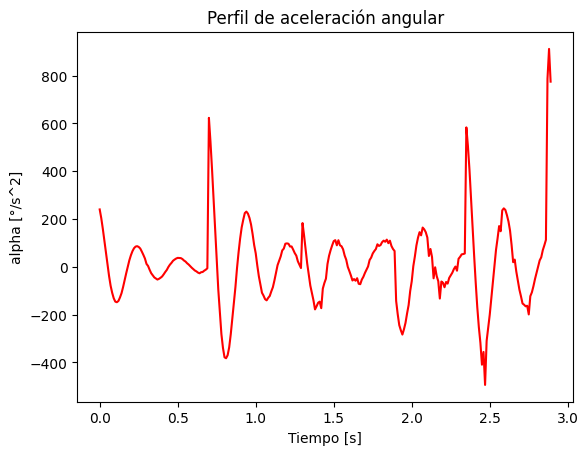

SIMULACIÓN CONTROLADOR PID DISCRETO


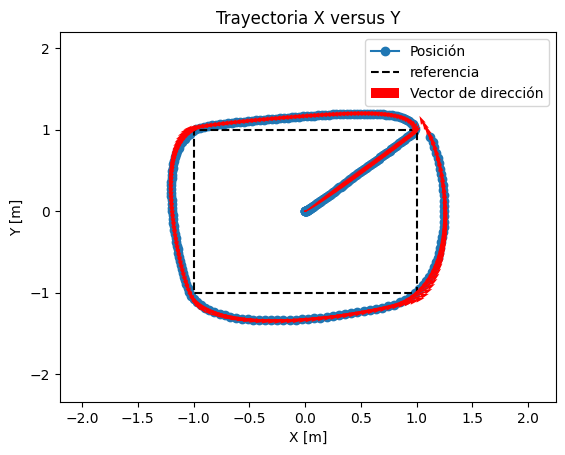

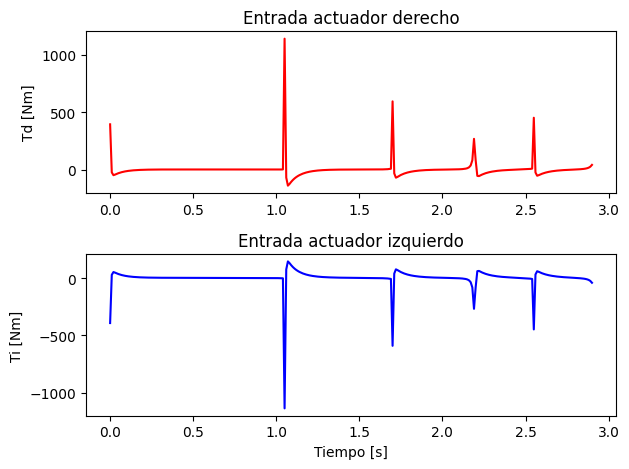

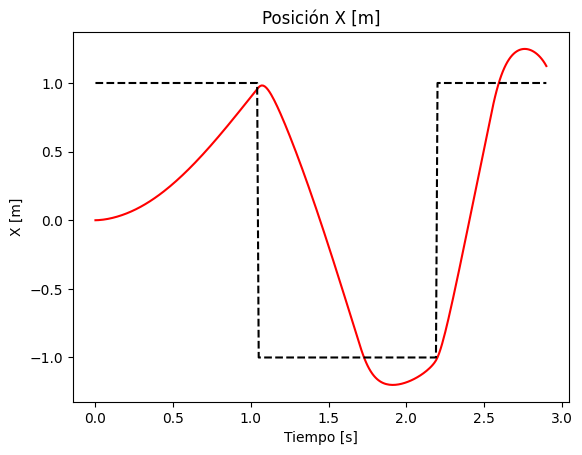

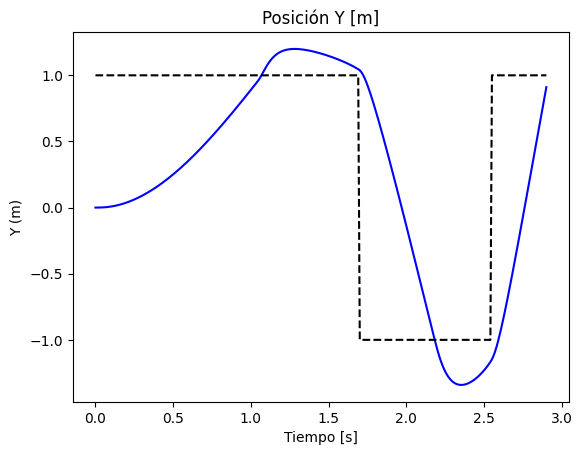

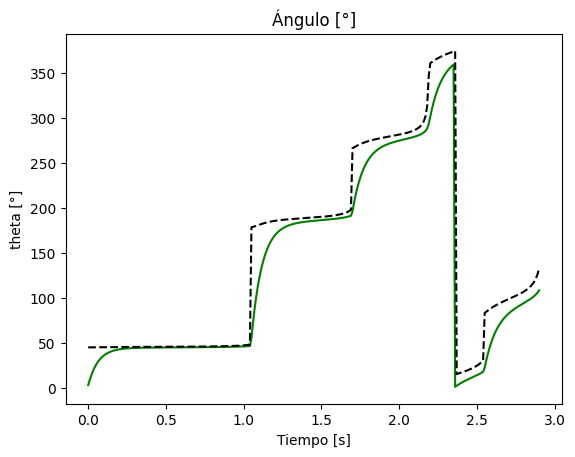

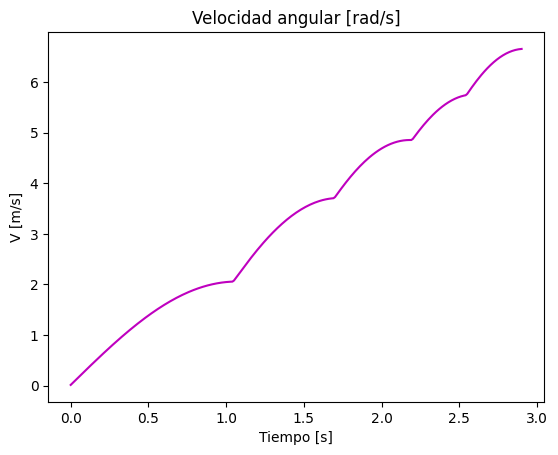

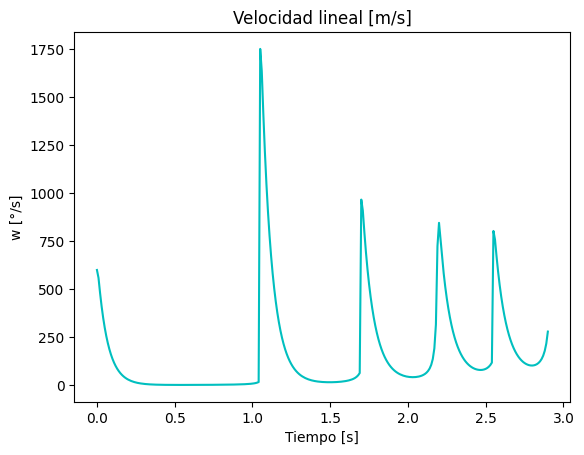

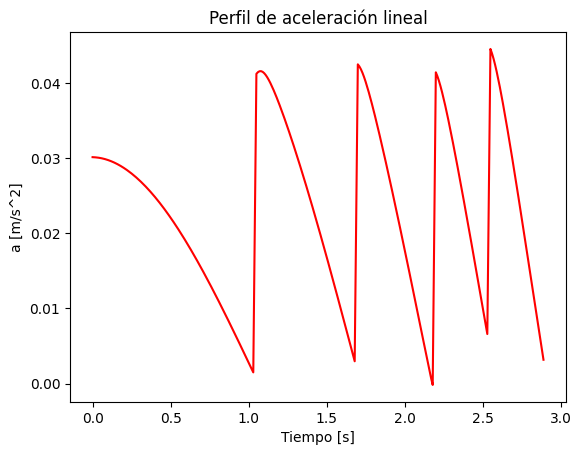

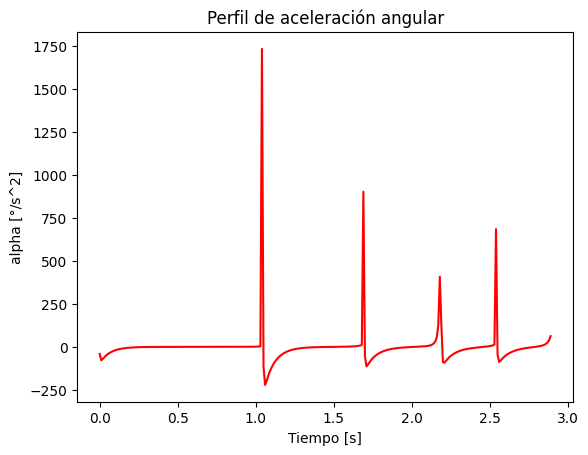

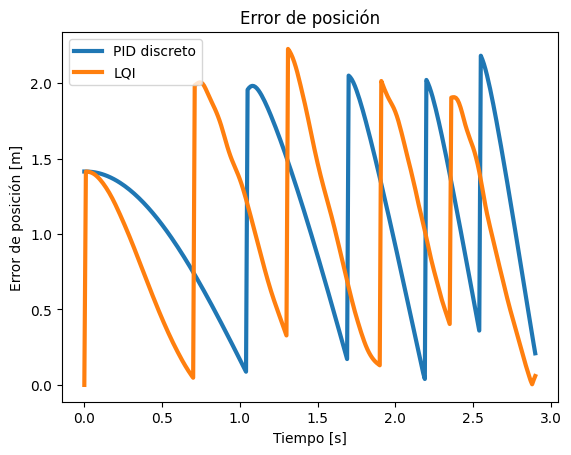

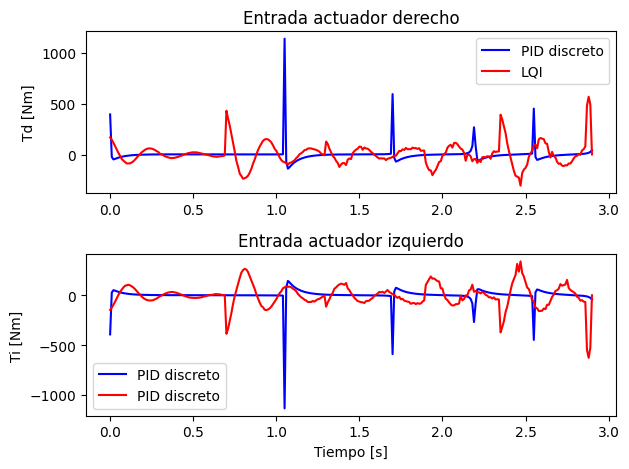

In [10]:
# semilla
np.random.seed(0)
t0 = 0.0 # Tiempo inicial
tf = 8.3 # Tiempo final 9.6, 11
Nsamples = int((tf-t0)/Ts)+1 # numero de muestras
t = np.linspace(t0, tf, Nsamples) # Vector de instantes de integración
x0 = np.array([0., 0., 0., 0., 0.]) # estado inicial
ref0 = np.array([0, 0]) # referencia
u0 = np.array([0, 0]) # entrada inicial
# incertudumbre inicial del estado x0
P0 = np.array([[0.01, 0, 0, 0, 0],
            [0, 0.01, 0, 0, 0],
            [0, 0, 0.03, 0, 0],
            [0, 0, 0, 0.01, 0],
            [0, 0, 0, 0, 0.03]])
# perturbaciones de estado con media 0 y varianza Qx iid
sigma_vx = np.array([10**(-4), 10**(-4), 3*10**(-4), 0.01, 0.03])
Qx = np.array([[10**(-4), 0, 0, 0, 0],
            [0, 10**(-4), 0, 0, 0],
            [0, 0, 3*10**(-4), 0, 0],
            [0, 0, 0, 0.01, 0],
            [0, 0, 0, 0, 0.03]])
# perturbaciones de entrada con media 0 y varianza Qu iid
sigma_vu = np.array([2*10**(-4)*m*r, 2*10**(-4)*m*r])
Qu = np.array([[2*10**(-4)*m*r, 0],
            [0, 2*10**(-4)*m*r]])
# ruido en los sensores (tacometro) iid -> medicion de velocidades
sigma_wt = np.array([10**(-4), 10**(-4)])
Rt = np.array([[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 10**(-4), 0],
            [0, 0, 0, 0, 10**(-4)]])
# ruido en los sensores (encoder) 
sigma_we = (np.pi*r**2/360)*np.array([[1, 2/W], [2/W, 4/(W**2)]])
Re = (np.pi*r**2/360)*np.array([[0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0],
                                [0, 0, 0, 1, 2/W],
                                [0, 0, 0, 2/W, 4/W**2]])
# ruido en los sensores (IMU) 
sigma_wi = np.array([0.0004, 0.0004*np.pi**2])
Ri = np.array([[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0.0004, 0],
            [0, 0, 0, 0, 0.0004*np.pi**2]])
# ruido en los sensores (GPS) 
sigma_wg = np.array([0.01, 0.01, 2./360.**2*np.pi, 0, 0])
Rg = (np.pi*r**2/360)*np.array([[0.01, 0, 0, 0, 0],
                                [0,  0.01, 0, 0, 0],
                                [0, 0, 0, 2./360.**2*np.pi, 0],
                                [0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0]])

############## EDITAR ###############
t1=0.7; t2=1.3; t3=1.9; t4=2.35
#t1 = 1
#t2 = 1.8
#t3 = 2.5
#t4 = 3.2
t0 = 0.0 # Tiempo inicial
tf = 2.9 # Tiempo final 9.6, 11
Nsamples = int((tf-t0)/Ts)+1 # numero de muestras
t = np.linspace(t0, tf, Nsamples) # Vector de instantes de integración
x0_lqi = np.array([0., 0., 0., 0., 0., 0., 0., 0])
P0_lqi = np.array([[0.01, 0, 0, 0, 0, 0, 0, 0],
            [0, 0.01, 0, 0, 0, 0, 0, 0],
            [0, 0, 0.03, 0, 0, 0, 0, 0],
            [0, 0, 0, 0.01, 0, 0, 0, 0],
            [0, 0, 0, 0, 0.03, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 1],])
sigma_vx_lqi = np.array([10**(-4), 10**(-4), 3*10**(-4), 0.01, 0.03, 10**(-4), 10**(-4), 10**(-4)])
jacob = 'LQI aumentado'
print('SIMULACIÓN CONTROLADOR LQI DISCRETO')
lista_entradas2, lista_error_pos2, lista_error_rumbo3 = simulador_lqi_discreto(t, x0_lqi, P0_lqi, sigma_vx_lqi, sigma_wg, 'GPS', jacob, t1, t2, t3, t4, True, 'cuadrada')
print('SIMULACIÓN CONTROLADOR PID DISCRETO')
lista_x, lista_ref_x, lista_ref_y, lista_entradas1, lista_ref_angle, lista_error_pos1, lista_error_rumbo1 = simular_pdi_discreto(t, x0, u0, sigma_vx, sigma_vu, ref0, 'cuadrada')
grafico_xy_orientacion(lista_x, lista_ref_x, lista_ref_y)
grafico_torques_entrada(lista_entradas1)
grafico_estado(lista_x, lista_ref_x, lista_ref_y, lista_ref_angle)
grafico_aceleracion(lista_x)

# grafico pregunta 3
graficos_p3 = True
#graficos_p3 = True
if graficos_p3 == True:
    fig1 = plt.figure()
    fig1.canvas.manager.set_window_title('Error de posición')
    plt.title('Error de posición')
    plt.plot(t, lista_error_pos1, linewidth = 3, label='PID discreto')
    plt.plot(t, lista_error_pos2, linewidth = 3, label='LQI')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Error de posición [m]')
    plt.legend()
    plt.show()
    fig2, (ax1, ax2) = plt.subplots(2, 1)
    fig2.canvas.manager.set_window_title('Señal de control')
    ax1.plot(t, lista_entradas1[:, 0], 'b', label='PID discreto')
    ax1.plot(t, lista_entradas2[:, 0], 'r', label='LQI')
    ax1.set_title('Entrada actuador derecho')
    ax1.set_ylabel('Td [Nm]')
    ax1.legend()
    ax2.plot(t, lista_entradas1[:, 1], 'b', label='PID discreto')
    ax2.plot(t, lista_entradas2[:, 1], 'r', label='PID discreto')
    ax2.set_title('Entrada actuador izquierdo')
    ax2.set_xlabel('Tiempo [s]')
    ax2.set_ylabel('Ti [Nm]')
    ax2.legend()
    plt.tight_layout()
    plt.show()

Simulación con referencia circular

SIMULACIÓN CONTROLADOR LQI DISCRETO


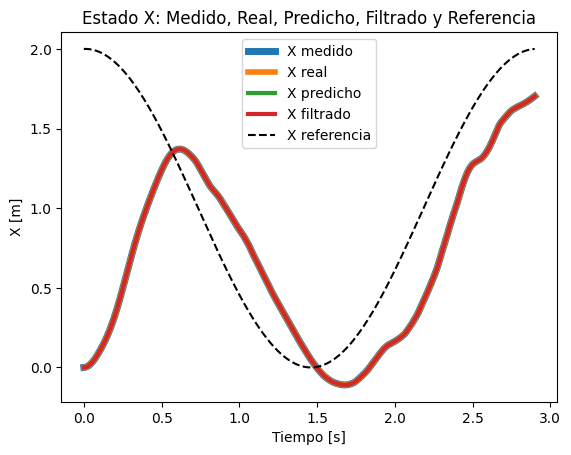

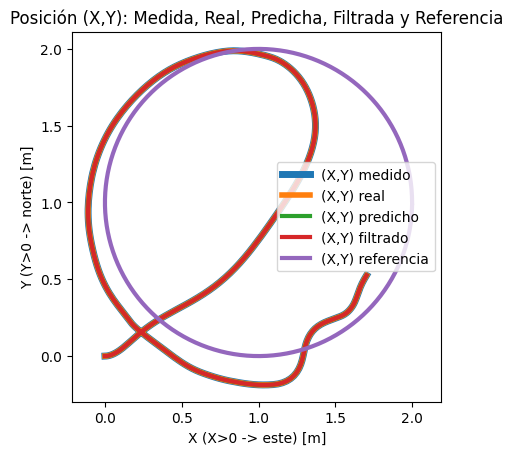

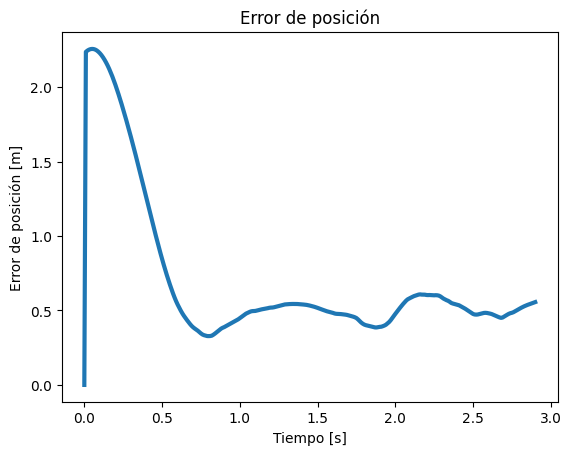

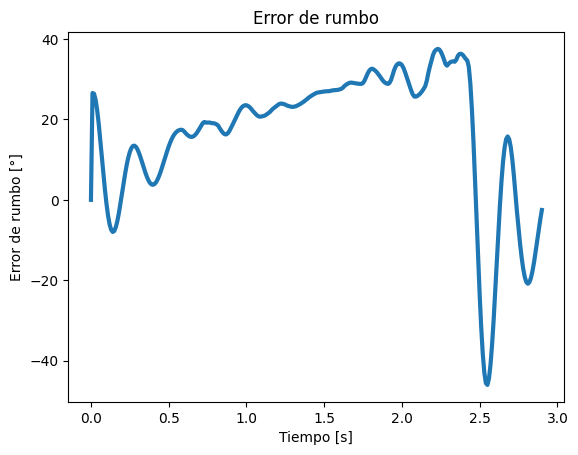

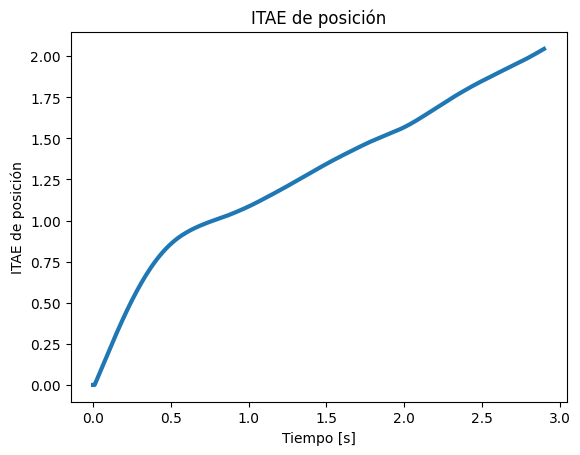

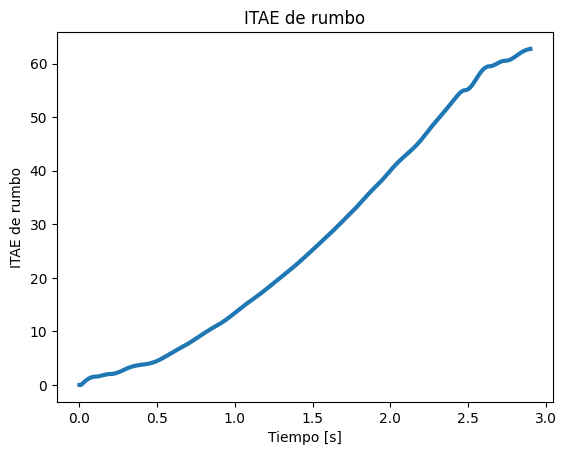

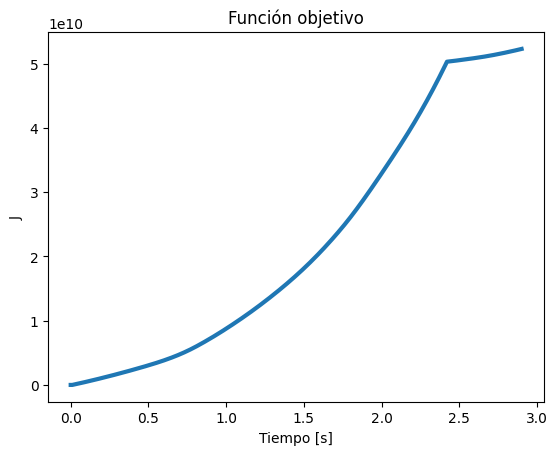

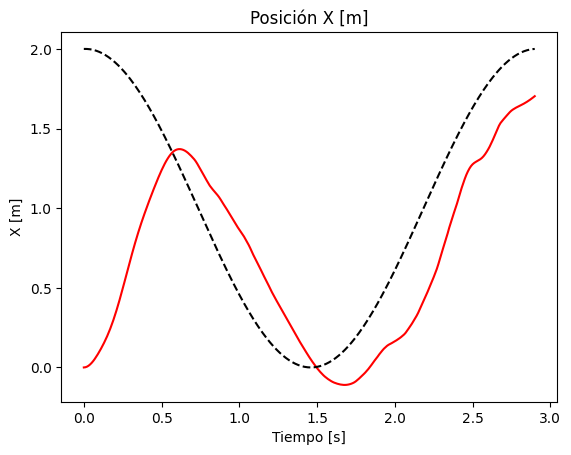

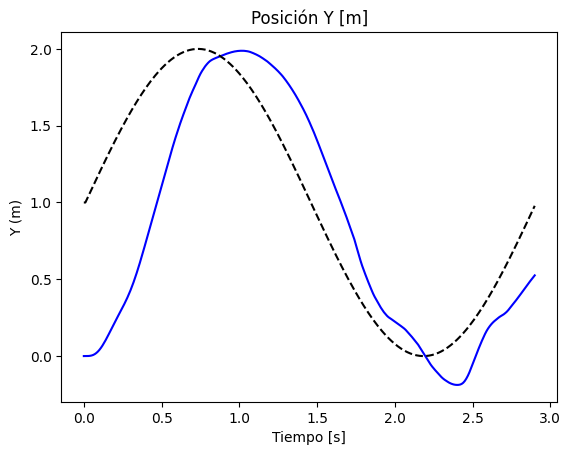

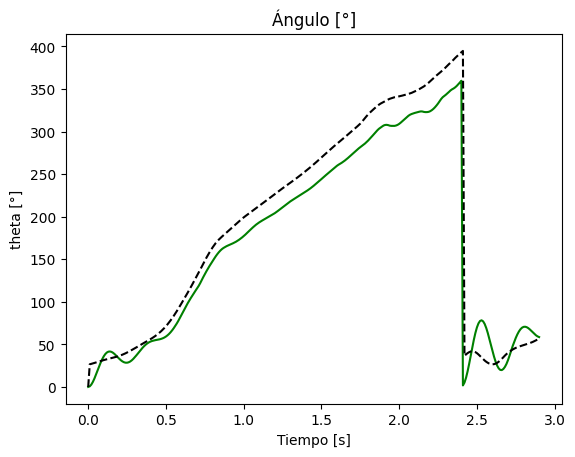

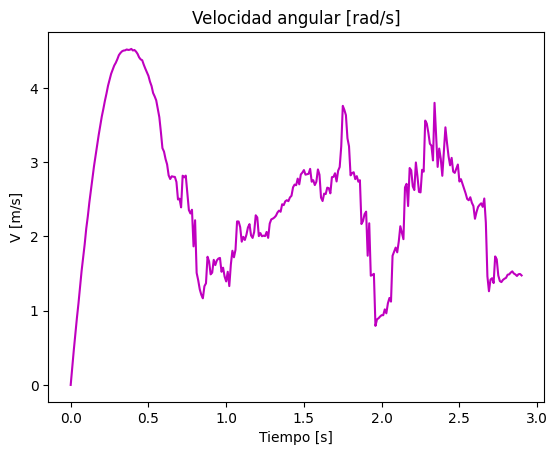

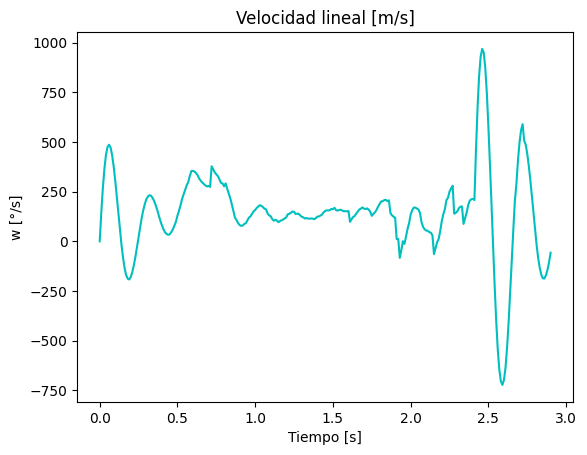

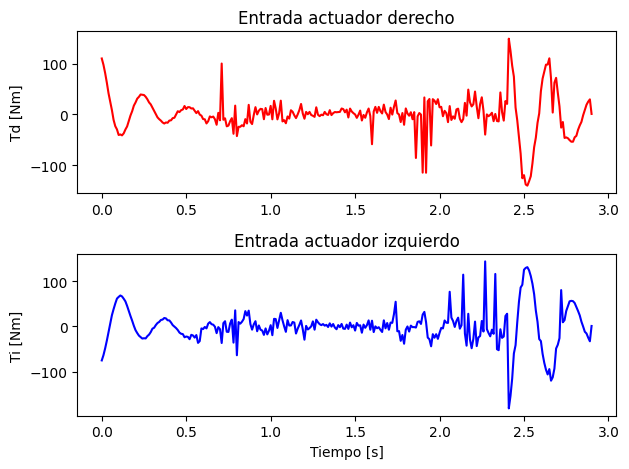

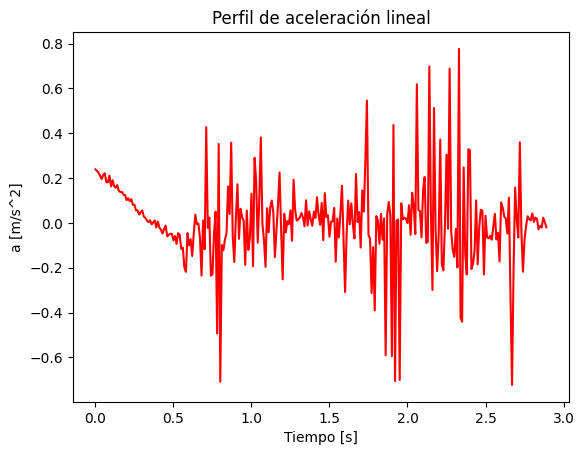

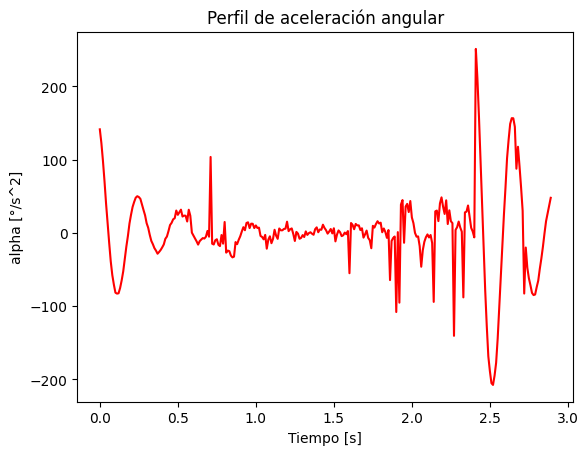

SIMULACIÓN CONTROLADOR PID DISCRETO


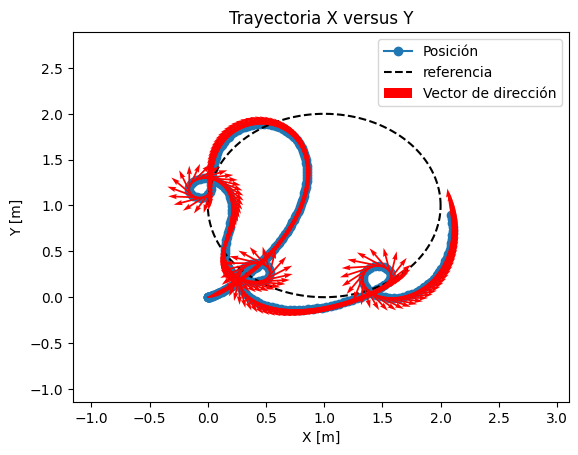

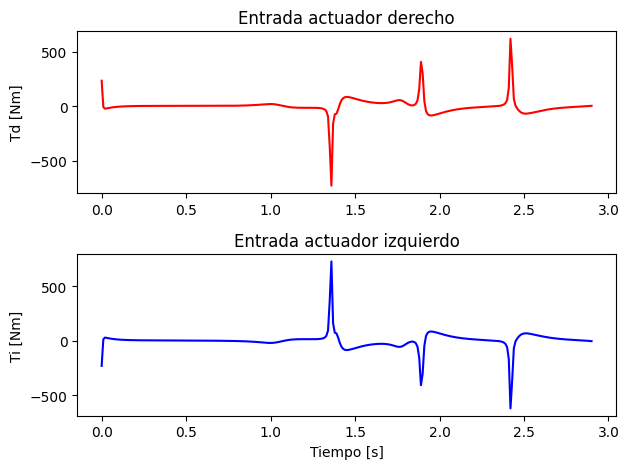

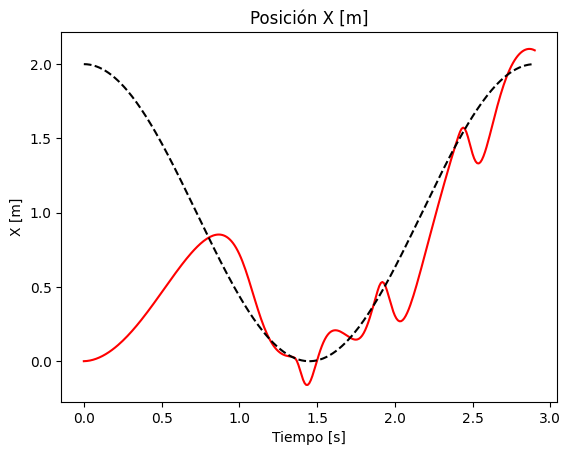

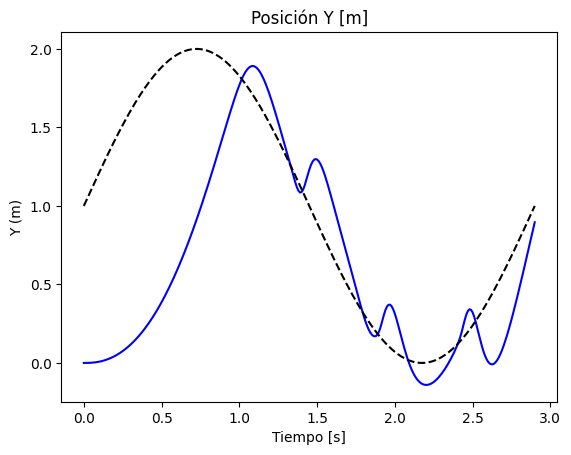

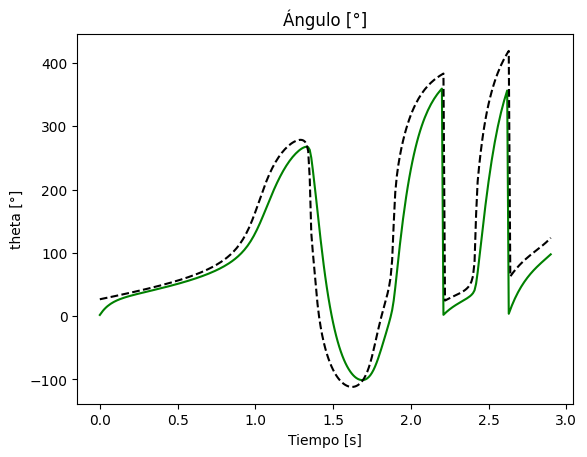

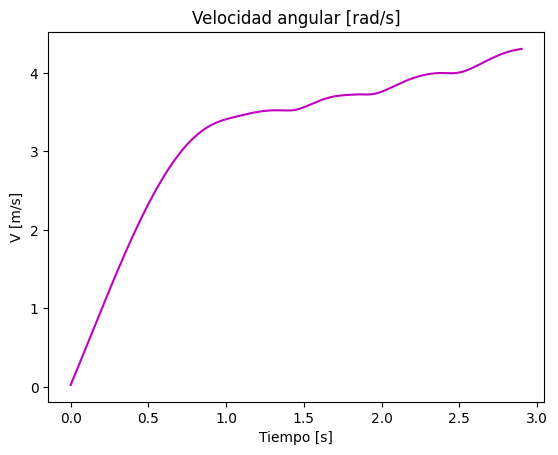

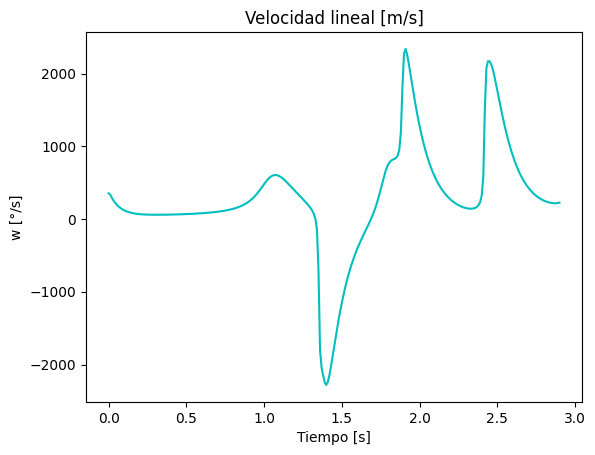

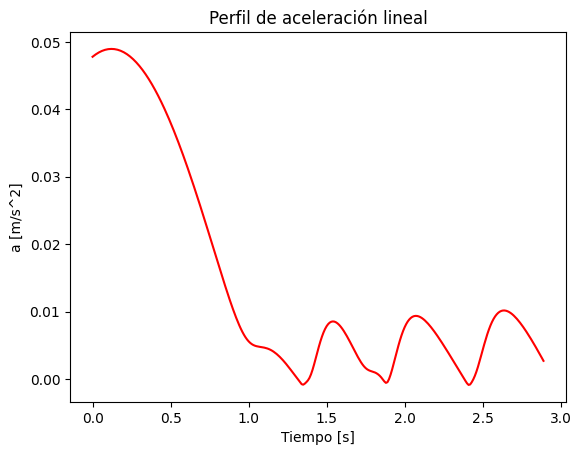

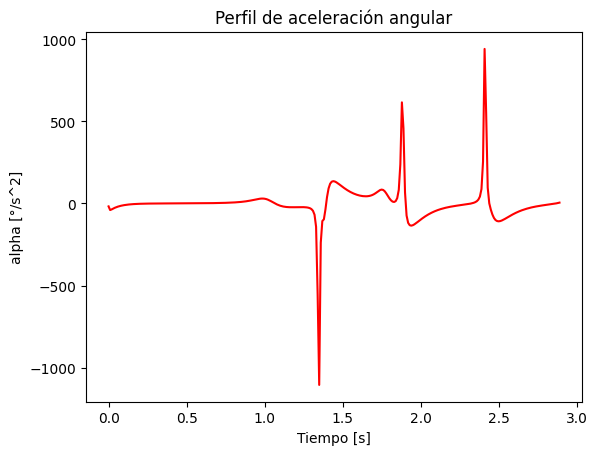

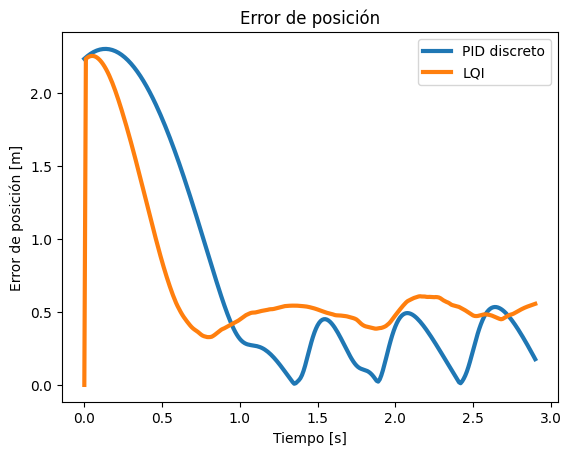

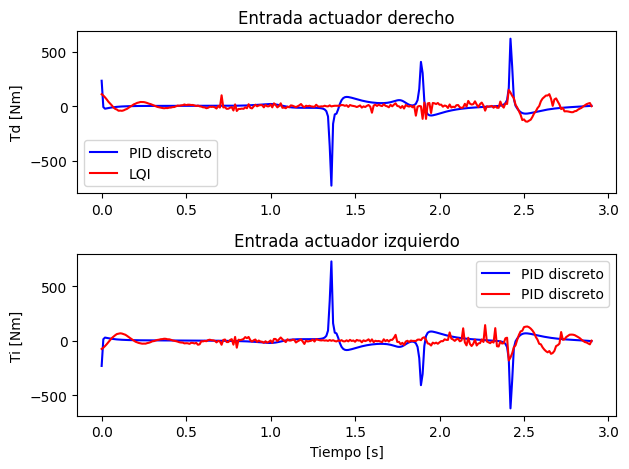

In [11]:
# semilla
np.random.seed(0)
t0 = 0.0 # Tiempo inicial
tf = 8.3 # Tiempo final 9.6, 11
Nsamples = int((tf-t0)/Ts)+1 # numero de muestras
t = np.linspace(t0, tf, Nsamples) # Vector de instantes de integración
x0 = np.array([0., 0., 0., 0., 0.]) # estado inicial
ref0 = np.array([0, 0]) # referencia
u0 = np.array([0, 0]) # entrada inicial
# incertudumbre inicial del estado x0
P0 = np.array([[0.01, 0, 0, 0, 0],
            [0, 0.01, 0, 0, 0],
            [0, 0, 0.03, 0, 0],
            [0, 0, 0, 0.01, 0],
            [0, 0, 0, 0, 0.03]])
# perturbaciones de estado con media 0 y varianza Qx iid
sigma_vx = np.array([10**(-4), 10**(-4), 3*10**(-4), 0.01, 0.03])
Qx = np.array([[10**(-4), 0, 0, 0, 0],
            [0, 10**(-4), 0, 0, 0],
            [0, 0, 3*10**(-4), 0, 0],
            [0, 0, 0, 0.01, 0],
            [0, 0, 0, 0, 0.03]])
# perturbaciones de entrada con media 0 y varianza Qu iid
sigma_vu = np.array([2*10**(-4)*m*r, 2*10**(-4)*m*r])
Qu = np.array([[2*10**(-4)*m*r, 0],
            [0, 2*10**(-4)*m*r]])
# ruido en los sensores (tacometro) iid -> medicion de velocidades
sigma_wt = np.array([10**(-4), 10**(-4)])
Rt = np.array([[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 10**(-4), 0],
            [0, 0, 0, 0, 10**(-4)]])
# ruido en los sensores (encoder) 
sigma_we = (np.pi*r**2/360)*np.array([[1, 2/W], [2/W, 4/(W**2)]])
Re = (np.pi*r**2/360)*np.array([[0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0],
                                [0, 0, 0, 1, 2/W],
                                [0, 0, 0, 2/W, 4/W**2]])
# ruido en los sensores (IMU) 
sigma_wi = np.array([0.0004, 0.0004*np.pi**2])
Ri = np.array([[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0.0004, 0],
            [0, 0, 0, 0, 0.0004*np.pi**2]])
# ruido en los sensores (GPS) 
sigma_wg = np.array([0.01, 0.01, 2./360.**2*np.pi, 0, 0])
Rg = (np.pi*r**2/360)*np.array([[0.01, 0, 0, 0, 0],
                                [0,  0.01, 0, 0, 0],
                                [0, 0, 0, 2./360.**2*np.pi, 0],
                                [0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0]])

############## EDITAR ###############
t1=0.7; t2=1.3; t3=1.9; t4=2.35
#t1 = 1
#t2 = 1.8
#t3 = 2.5
#t4 = 3.2
t0 = 0.0 # Tiempo inicial
tf = 2.9 # Tiempo final 9.6, 11
Nsamples = int((tf-t0)/Ts)+1 # numero de muestras
t = np.linspace(t0, tf, Nsamples) # Vector de instantes de integración
x0_lqi = np.array([0., 0., 0., 0., 0., 0., 0., 0])
P0_lqi = np.array([[0.01, 0, 0, 0, 0, 0, 0, 0],
            [0, 0.01, 0, 0, 0, 0, 0, 0],
            [0, 0, 0.03, 0, 0, 0, 0, 0],
            [0, 0, 0, 0.01, 0, 0, 0, 0],
            [0, 0, 0, 0, 0.03, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 1],])
sigma_vx_lqi = np.array([10**(-4), 10**(-4), 3*10**(-4), 0.01, 0.03, 10**(-4), 10**(-4), 10**(-4)])
jacob = 'LQI aumentado'
print('SIMULACIÓN CONTROLADOR LQI DISCRETO')
lista_entradas2, lista_error_pos2, lista_error_rumbo3 = simulador_lqi_discreto(t, x0_lqi, P0_lqi, sigma_vx_lqi, sigma_wg, 'GPS', jacob, t1, t2, t3, t4, True, 'circular')
print('SIMULACIÓN CONTROLADOR PID DISCRETO')
lista_x, lista_ref_x, lista_ref_y, lista_entradas1, lista_ref_angle, lista_error_pos1, lista_error_rumbo1 = simular_pdi_discreto(t, x0, u0, sigma_vx, sigma_vu, ref0, 'circular')
grafico_xy_orientacion(lista_x, lista_ref_x, lista_ref_y)
grafico_torques_entrada(lista_entradas1)
grafico_estado(lista_x, lista_ref_x, lista_ref_y, lista_ref_angle)
grafico_aceleracion(lista_x)

# grafico pregunta 3
graficos_p3 = True
#graficos_p3 = True
if graficos_p3 == True:
    fig1 = plt.figure()
    fig1.canvas.manager.set_window_title('Error de posición')
    plt.title('Error de posición')
    plt.plot(t, lista_error_pos1, linewidth = 3, label='PID discreto')
    plt.plot(t, lista_error_pos2, linewidth = 3, label='LQI')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Error de posición [m]')
    plt.legend()
    plt.show()
    fig2, (ax1, ax2) = plt.subplots(2, 1)
    fig2.canvas.manager.set_window_title('Señal de control')
    ax1.plot(t, lista_entradas1[:, 0], 'b', label='PID discreto')
    ax1.plot(t, lista_entradas2[:, 0], 'r', label='LQI')
    ax1.set_title('Entrada actuador derecho')
    ax1.set_ylabel('Td [Nm]')
    ax1.legend()
    ax2.plot(t, lista_entradas1[:, 1], 'b', label='PID discreto')
    ax2.plot(t, lista_entradas2[:, 1], 'r', label='PID discreto')
    ax2.set_title('Entrada actuador izquierdo')
    ax2.set_xlabel('Tiempo [s]')
    ax2.set_ylabel('Ti [Nm]')
    ax2.legend()
    plt.tight_layout()
    plt.show()

De la respuesta de los gráficos se puede observar que el controlador PID tiene un mejor seguimiento de referencia, tanto de ángulo como de distancia. Se puede notar que ambos controladores tienen constantes de tiempo diferentes puesto que el controlador LQI recorre más distancia y es más rápido, el controlador PID es más lento pero más directo, si observamos la trayectoria circular el PID llega rapidamente a la referencia girando sobre el propio punto de referencia.